**<h1 style="text-align:center;font-size:30px;" > Quora Question Pair Similarity </h1>**

**<h2> Description </h2>**

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
(Credits: <a href = 'https://www.kaggle.com/c/quora-question-pairs/overview'>Kaggle</a>) 


## **Problem Statement**
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

**<h2> Real world/Business Objectives and Constraints </h2>**

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

**<h3> Data Overview </h3>**

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

**<h3> Example Data point </h3>**

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

**<h2> Mapping the real world problem to an ML problem </h2>**

<h3>Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

**<h3> Performance Metric </h3>**

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss: Since we want probabilistic outputs, it's best to use log-loss which would punish on low confidence scores.
* Binary Confusion Matrix: : To easily visualize the performance of model for each class.

**<h1> Exploratory Data Analysis </h1>**

In [ ]:
pip install distance

     |████████████████████████████████| 184kB 5.3MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp37-none-any.whl size=16261 sha256=cf2209b8d7c721ceca7dcac229bd9ee81b69939a12be263c909b048199d580e7
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [ ]:
pip install pyspellchecker

     |████████████████████████████████| 2.7MB 4.1MB/s 


In [ ]:
pip install fuzzywuzzy

In [ ]:
#importing libraries

import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import distance

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from spellchecker import SpellChecker
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**<h2> Reading data and basic stats </h2>**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/train.csv")
print("Number of data points:",df.shape[0])
df.head()

Number of data points: 404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

**<h3> Distribution of data points**

In [ ]:
df.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

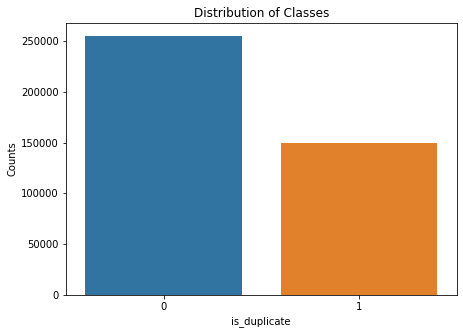

In [ ]:
plt.figure(figsize=(7,5))
a=df.is_duplicate.value_counts()
sns.barplot(x=a.index,y=a.values)
plt.xlabel('is_duplicate')
plt.ylabel('Counts')
plt.title("Distribution of Classes")
plt.show()

**<h2> Nan values**

In [ ]:
#checking for total NaN values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
#printing the rows with NaN values
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
#since there are only two NaN values, we remove them
df=df.dropna()

**<h2>Other stats**

In [ ]:
print("Question pairs that are similar = ", np.mean(df.is_duplicate)*100," %",sep='')
print("Question pairs that are not similar = ",(1-np.mean(df.is_duplicate))*100," %",sep='')

Question pairs that are similar = 36.92005926482919 %
Question pairs that are not similar = 63.0799407351708 %


**Number of unique questions** 

In [ ]:
questions=pd.Series(df.question1.tolist()+df.question2.tolist())
print("Total unique questions =",questions.value_counts().shape[0])

print("No. of questions that appear more than one time =", np.sum(questions.value_counts()>1))

print("Max no. of times a question was repeated =",max(questions.value_counts()))

Total unique questions = 537359
No. of questions that appear more than one time = 111870
Max no. of times a question was repeated = 161


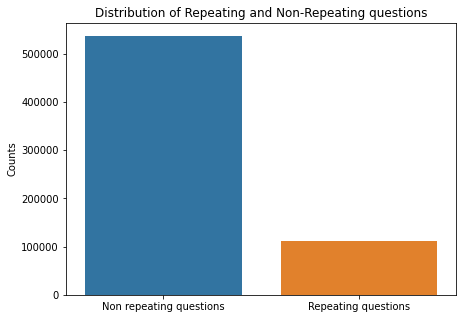

In [ ]:
plt.figure(figsize=(7,5))
question_unique_occurrences = questions.value_counts()
sns.barplot(x=['Non repeating questions','Repeating questions'],y=[question_unique_occurrences.shape[0],
                                                                   np.sum(question_unique_occurrences>1)])
plt.ylabel('Counts')
plt.title("Distribution of Repeating and Non-Repeating questions")
plt.show()

In [ ]:
#checking for duplicates
print("Total number of duplicate entries =", df.duplicated(subset=['question1','question2']).sum())

Total number of duplicate entries = 0


**<h3> Number of occurrences of each question </h3>**

Maximum number of times a single question is repeated: 425489



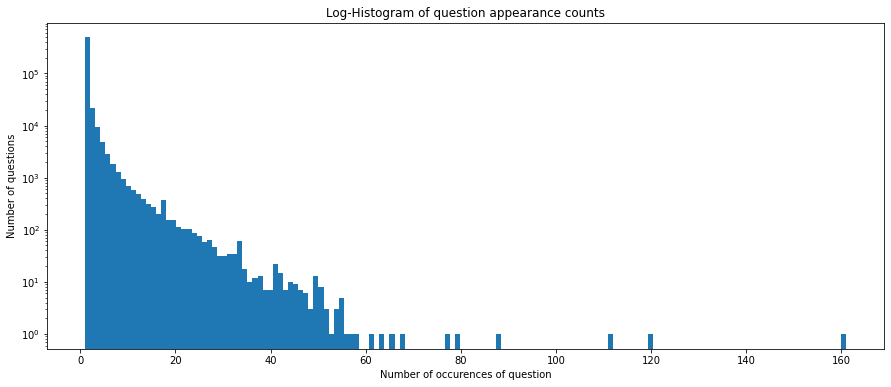

In [ ]:
plt.figure(figsize=(15,6))
plt.hist(question_unique_occurrences.values, bins=150)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(
                max(question_unique_occurrences.value_counts()))) 
plt.show()

#**Feature Engineering**

**<h2> Basic Feature Extraction (before text preprocessing) </h2>**

Let us now construct a few features like:
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)

In [ ]:
df['q1len'] = df.question1.str.len()
df['q2len'] = df.question2.str.len()

df['q1_n_words'] = df.question1.apply(lambda x:len(x.split()))
df['q2_n_words'] = df.question2.apply(lambda x:len(x.split()))

df['word_Common'] = [len(set(ele[0].lower().strip("?").split()).intersection(set(ele[1].lower().strip("?").split()))) \
                    for ele in zip(df.question1,df.question2)]

df['word_Total'] = [len(set(ele[0].lower().strip("?").split()).union(set(ele[1].lower().strip("?").split()))) \
                   for ele in zip(df.question1,df.question2)]
                   
df['word_share'] = df['word_Common']/df['word_Total']

df.word_share=df.word_share.fillna(0)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,11,12,0.916667
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,5,15,0.333333
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4,20,0.200000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,3,17,0.176471


**Analysis of some of the extracted features**

<h4> Feature: questions lenth </h4>

In [ ]:
min_q1 = min(df.q1_n_words)
min_q2 = min(df.q2_n_words)
max_q1 = max(df.q1_n_words)
max_q2 = max(df.q2_n_words)

print("Minimum length of question in question1 =",min_q1)
print("Minimum length of question in question2 =",min_q2)
print("Maximum length of question in question1 =",max_q1)
print("Maximum length of question in question2 =",max_q2)

print("No. of questions with max length", df[df.q1_n_words==max_q1].shape[0]+df[df.q2_n_words==max_q2].shape[0])

Minimum length of question in question1 = 1
Minimum length of question in question2 = 1
Maximum length of question in question1 = 125
Maximum length of question in question2 = 237
No. of questions with max length 14


**<h4> Feature: word_share </h4>**

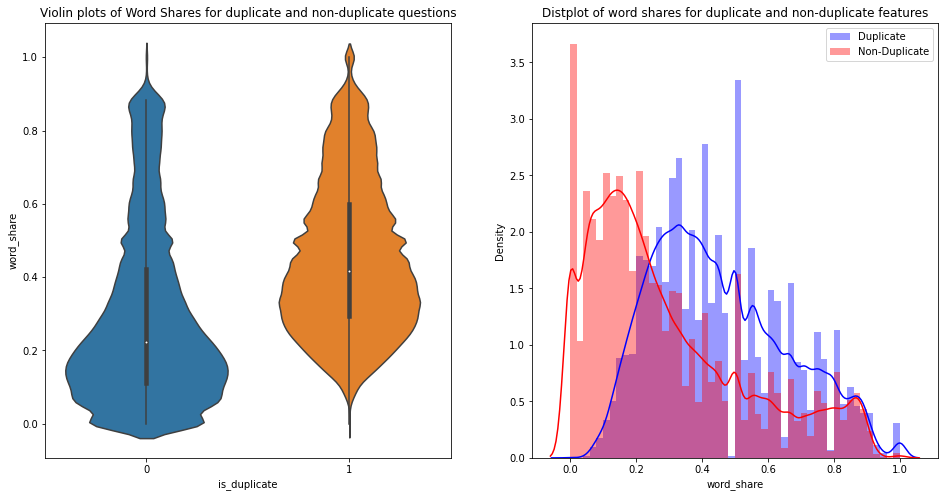

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.title('Violin plots of Word Shares for duplicate and non-duplicate questions')
sns.violinplot(x=df.is_duplicate,y=df.word_share)

plt.subplot(1,2,2)
plt.title("Distplot of word shares for duplicate and non-duplicate features")
sns.distplot(df.word_share[df.is_duplicate==1][0:],label='Duplicate',color='blue')
sns.distplot(df.word_share[df.is_duplicate==0][0:],label='Non-Duplicate',color='red')
plt.legend()
               
plt.show()

From the above plot, we notice that the word share for duplicate questions tend to be slightly higher than non-duplicate questions.

**<h4> Feature: word_Common </h4>**

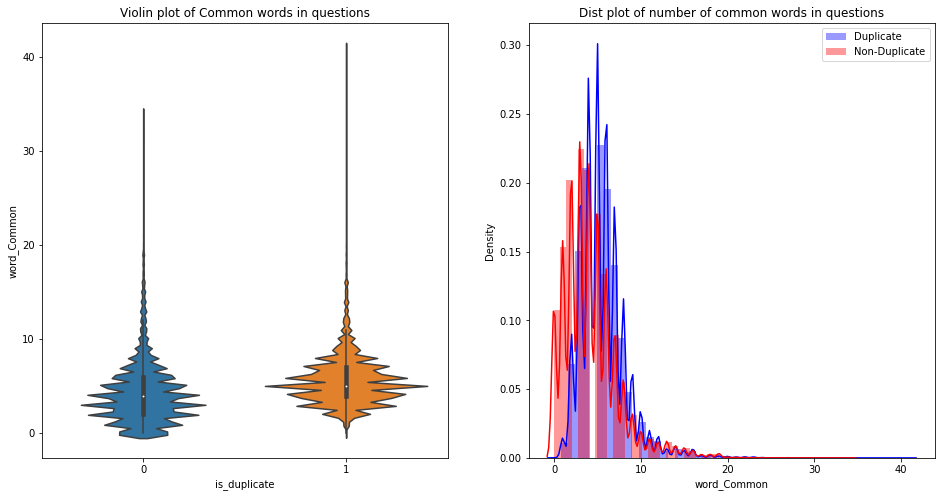

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.title('Violin plot of Common words in questions')
sns.violinplot(x=df.is_duplicate,y=df.word_Common)

plt.subplot(1,2,2)
plt.title("Dist plot of number of common words in questions")
sns.distplot(df.word_Common[df.is_duplicate==1][0:],label='Duplicate',color='blue')
sns.distplot(df.word_Common[df.is_duplicate==0][0:],label='Non-Duplicate',color='red')
plt.legend()

plt.show()

The distribution of Number of common words is pretty similar among the both.

**<h3> Text Preprocessing <h3>**

For preprocessing the text, we will employ the following strategy:

*   Removing HTML Tags
*   Decontracting the words, and also converting numbers in the form of millions (m) and thousands (k)
*   Removing the links, if present
*   Cleaning the punctuations
*   Stemming the words


In [ ]:
def clean_punc(sentence):
    s=re.sub(r'[/|\|?|…|,|.|:|||;|{|}|\'|+|\-|\"|!|@|#|$|%|^|&|*|(|)|“|”|]',' ',sentence)
    s=s.replace('[',' ').replace(']',' ').replace('\\',' ')
    return s

def link_remover(sentence):
    s=re.sub(r'http://s*\w+\.\w+\.?\w*',' ',sentence)
    return s

def miscellaneous(text):
    text=text.replace('\'ve',' have').replace('n\'t',' not').replace('won\'t','will not').\
            replace('can\'t','can not').replace('\'d',' would').replace('\'m',' am').\
            replace('\'ll',' will').replace('\'re',' are').replace('\'s',' is').\
            replace("€", " euro ").replace(",000,000", "m").replace(",000", "k").\
            replace("′", "'").replace("’", "'").replace("cannot", "can not").\
            replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ").\
            replace("€", " euro ")
    text = re.sub(r"([0-9]+)000000", r"\1m", text)
    text = re.sub(r"([0-9]+)000", r"\1k", text)
    return text

def cleanHtml(text):
    pattern=re.compile(r'<.*?>')
    cleantext=re.sub(pattern,' ',text)
    return cleantext

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

spell=SpellChecker()

snow=SnowballStemmer('english')

In [ ]:
def preprocess(corpus):
    final=[]
    for x in tqdm(corpus):
        x=cleanHtml(x)
        x=miscellaneous(x)
        x=link_remover(x)
        x=clean_punc(x)
        
        sent=[]
        for ele in x.split():
            w=snow.stem(ele.lower())
            sent.append(w)
        
        final.append(' '.join(sent))   
    return final

In [ ]:
df['question1'] = preprocess(df.question1)
df['question2'] = preprocess(df.question2)
df.head()

100%|██████████| 404287/404287 [01:06<00:00, 6086.73it/s]


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,66,57,14,12,11,12,0.916667
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,51,88,8,13,5,15,0.333333
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,73,59,14,10,4,20,0.200000
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,50,65,11,9,0,19,0.000000
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,76,39,13,7,3,17,0.176471


**<h2> Advanced Feature Extraction (NLP and Fuzzy Features) </h2>**

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br> 
<br>

- __last_word_eq__ :  Check if last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>      
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __longest_substr_ratio__ :  Ratio of length longest common substring to min length of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [ ]:
def tokenization(q1,q2):
    token_features = [0.0]*15
    
    #getting the tokens
    question_1_tokens = q1.split()
    question_2_tokens = q2.split()
    
    #checking if any of the two questions have 0 words
    if len(question_1_tokens) == 0 or len(question_2_tokens) == 0:
        return token_features
    
    #getting the stop words
    q1_stop=set([ele for ele in question_1_tokens if ele in stopwords])
    q2_stop=set([ele for ele in question_2_tokens if ele in stopwords])
    
    #getting the words
    q1_word=set(question_1_tokens)-q1_stop
    q2_word=set(question_2_tokens)-q2_stop
    
    #cwc_min and cwc_max
    token_features[0]=len(q1_word.intersection(q2_word))/(min(len(q1_word),len(q2_word))+0.0001) 
    token_features[1]=len(q1_word.intersection(q2_word))/(max(len(q1_word),len(q2_word))+0.0001)
    
    #csc_min and csc_max
    token_features[2]=len(q1_stop.intersection(q2_stop))/(min(len(q1_stop),len(q2_stop))+0.0001)
    token_features[3]=len(q1_stop.intersection(q2_stop))/(max(len(q1_stop),len(q2_stop))+0.0001)
    
    #ctc_min and ctc_max
    token_features[4]=len(set(question_1_tokens).intersection(set(question_2_tokens)))/(min(len(question_1_tokens),\
                        len(question_2_tokens))+0.00001)
    token_features[5]=len(set(question_1_tokens).intersection(set(question_2_tokens)))/(max(len(question_1_tokens),\
                        len(question_2_tokens))+0.00001)
    
    #last_word_eq and first_word_eq
    token_features[6]=int(question_1_tokens[-1]==question_2_tokens[-1])
    token_features[7]=int(question_1_tokens[0]==question_2_tokens[0])
    
    #abs_len_diff and mean_len
    token_features[8]=abs(len(question_1_tokens)-len(question_2_tokens))
    token_features[9]=(len(question_1_tokens)+len(question_2_tokens))/2
    
    #fuzzy ratios
    token_features[10]=fuzz.ratio(q1.lower(),q2.lower())
    token_features[11]=fuzz.partial_ratio(q1.lower(),q2.lower())
    token_features[12]=fuzz.token_sort_ratio(q1.lower(),q2.lower())
    token_features[13]=fuzz.token_set_ratio(q1.lower(),q2.lower())
    
    #getting the longest common substring ratio
    dist=distance.lcsubstrings(q1,q2)
    if dist==0:
        d=0
    else:
        d=len(dist)/(min(len(question_1_tokens),len(question_2_tokens))+0.0001)
        
    token_features[14]=d
    
    return token_features
    
def extract_features(df):
    token_features = df.apply(lambda x: tokenization(x.question1,x.question2), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    df["fuzz_ratio"]            = list(map(lambda x: x[10], token_features))
    df["fuzz_partial_ratio"]    = list(map(lambda x: x[11], token_features))
    df["token_sort_ratio"]      = list(map(lambda x: x[12], token_features))
    df["token_set_ratio"]       = list(map(lambda x: x[13], token_features))
    df["longest_substr_ratio"]  = list(map(lambda x: x[14], token_features))
    
    return df

In [ ]:
print("Extracting features for train:")
df = extract_features(df)
print("Done.")
df.head()

Extracting features for train:
Done.


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0,66,57,14,12,11,12,0.916667,0.999980,0.833319,0.999983,0.999983,0.916666,0.785714,0.0,1.0,2.0,13.0,92.0,100.0,92.0,100.0,0.083333
1,1,3,4,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,51,88,8,13,5,15,0.333333,0.799984,0.399996,0.749981,0.599988,0.699999,0.466666,0.0,1.0,5.0,12.5,67.0,71.0,65.0,86.0,0.099999
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0,73,59,14,10,4,20,0.200000,0.599988,0.499992,0.399992,0.249997,0.500000,0.357143,0.0,1.0,4.0,12.0,39.0,38.0,64.0,72.0,0.099999
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...,0,50,65,11,9,0,19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,22.0,27.0,27.0,31.0,0.545450
4,4,9,10,which one dissolv in water quik sugar salt met...,which fish would surviv in salt water,0,76,39,13,7,3,17,0.176471,0.399992,0.199998,0.999950,0.666644,0.571428,0.307692,0.0,1.0,6.0,10.0,36.0,54.0,50.0,68.0,0.428565


**<h3> Analysis of extracted features </h3>**

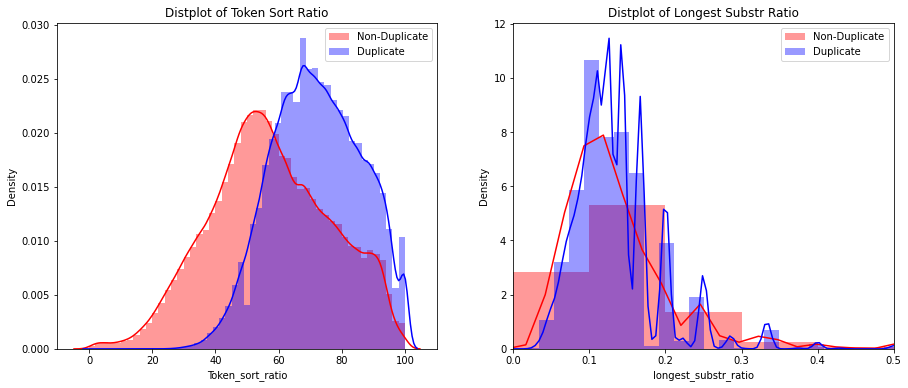

In [ ]:
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.title('Distplot of Token Sort Ratio')
sns.distplot(df.token_sort_ratio[df.is_duplicate==0], label='Non-Duplicate',color='red')
sns.distplot(df.token_sort_ratio[df.is_duplicate==1],label='Duplicate',color='blue')
plt.xlabel("Token_sort_ratio")
plt.legend()

plt.subplot(1,2,2)
plt.title('Distplot of Longest Substr Ratio')
sns.distplot(df.longest_substr_ratio[df.is_duplicate==0], label='Non-Duplicate',color='red')
sns.distplot(df.longest_substr_ratio[df.is_duplicate==1],label='Duplicate',color='blue')
plt.xlabel('longest_substr_ratio')
plt.xlim(0,0.5)
plt.legend()
plt.show()

From the above plot, we notice that there is some differentiability among the classes using Token_sort_ratio, but not with longest_substr_ratio.

Pair scatter plots between Token_sort_ratio, fuzz_partial_ratio and longest_substr_ratio


<Figure size 1800x720 with 0 Axes>

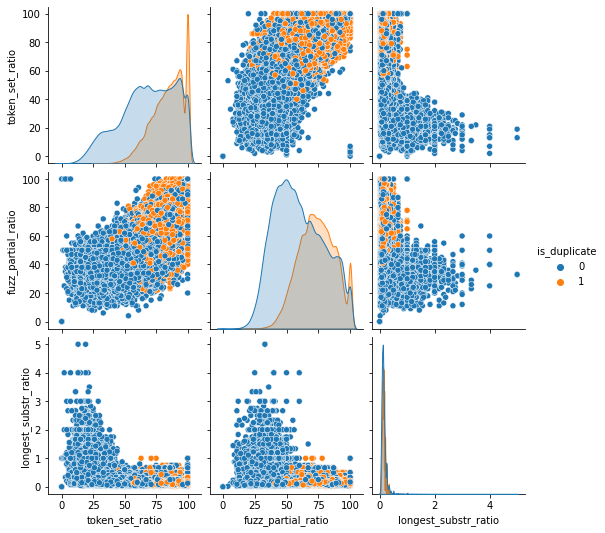

In [ ]:
plt.figure(figsize=(25,10))
print("Pair scatter plots between Token_sort_ratio, fuzz_partial_ratio and longest_substr_ratio")
sns.pairplot(df,hue='is_duplicate',vars=['token_set_ratio','fuzz_partial_ratio','longest_substr_ratio'])
plt.show()

We can see Good separability between Duplicates and non-duplicates from the plot between Token_sort_ratio and longest_substr_ratio, and also between longest_substr_ratio and fuzz_partial_ratio. This implies that our features seem to be working well.

**<h3> Removing stop words from questions <h3>**

In [ ]:
#now that we have created our features, we can remove the stopwords from the questions
df.question1=[' '.join([w for w in ele.split() if w not in stopwords and len(w)>=2]) for ele in df.question1]
df.question2=[' '.join([w for w in ele.split() if w not in stopwords and len(w)>=2]) for ele in df.question2]
#we might have created some NaN values, so for them, we drop the NaNs
df = df.dropna()

**<h3> Wordclouds**

In [ ]:
# Creating wordclouds for both duplicate and non duplicate sets of questions
df_duplicates = df[['question1','question2']][df.is_duplicate==1]
df_non_duplicates=df[['question1','question2']][df.is_duplicate==0]

duplicates=np.hstack([np.array(df_duplicates.question1),np.array(df_duplicates.question2)])
non_duplicates=np.hstack([np.array(df_non_duplicates.question1),np.array(df_non_duplicates.question2)])

words_in_duplicates=[]
for ele in duplicates:
    words_in_duplicates.extend(ele.split())
words_in_duplicates=set(words_in_duplicates)

words_in_non_duplicates=[]
for ele in non_duplicates:
    words_in_non_duplicates.extend(ele.split())
words_in_non_duplicates=set(words_in_non_duplicates)

**<h3> Wordcloud for duplicate question pairs <h3>**

Word Cloud for Duplicate Question pairs


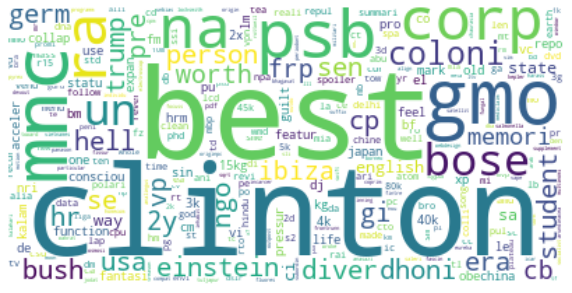

In [ ]:
wc = WordCloud(background_color="white", max_words=len(words_in_duplicates))
wc.generate(' '.join(list(words_in_duplicates)))

plt.figure(figsize=(10,7))
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**<h3> Wordcloud for non-duplicate question pairs <h3>**

Word Cloud for Non-Duplicate Question pairs


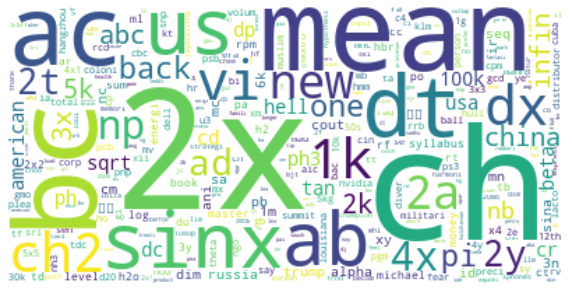

In [ ]:
wc = WordCloud(background_color="white", max_words=len(words_in_non_duplicates))
wc.generate(' '.join(list(words_in_non_duplicates)))

plt.figure(figsize=(10,7))
print ("Word Cloud for Non-Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**<h3> Train Test Split <h3>**

In [ ]:
Y = df.pop('is_duplicate')
X = df
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,stratify=Y)

In [ ]:
#printing the shapes of train and test set
print("Shape of x_train =", x_train.shape)
print("Shape of x_test =", x_test.shape)
print("Shape of y_train =", y_train.shape)
print("Shpae of y_test =", y_test.shape)

Shape of x_train = (283000, 27)
Shape of x_test = (121287, 27)
Shape of y_train = (283000,)
Shpae of y_test = (121287,)


**<h3> Adding some more features <h3>**

**freq_qid1** = Frequency of qid1's

**freq_qid2** = Frequency of qid2's

**freq_q1+freq_q2** = sum total of frequency of qid1 and qid2

**freq_q1-freq_q2** = absolute difference of frequency of qid1 and qid2

In [ ]:
freq_qid1_train = dict(x_train.qid1.value_counts())
x_train['freq_qid1'] = [freq_qid1_train[ele] for ele in x_train.qid1]
x_test['freq_qid1'] = [freq_qid1_train.get(ele, 0) for ele in x_test.qid1]

freq_qid2_train = dict(x_train.qid2.value_counts())
x_train['freq_qid2'] = [freq_qid2_train[ele] for ele in x_train.qid2]
x_test['freq_qid2'] = [freq_qid2_train.get(ele, 0) for ele in x_test.qid1]

x_train['freq_q1+freq_q2'] = x_train['freq_qid1'] + x_train['freq_qid2']
x_train['freq_q1-freq_q2'] = np.abs(x_train['freq_qid1'] - x_train['freq_qid2'])
x_test['freq_q1+freq_q2'] = x_test['freq_qid1'] + x_test['freq_qid2']
x_test['freq_q1-freq_q2'] = np.abs(x_test['freq_qid1'] - x_test['freq_qid2'])

**<h3> Saving to CSV File <h3>**

In [ ]:
x_training=pd.concat([x_train,y_train],axis=1)
x_testing=pd.concat([x_test,y_test],axis=1)

x_training.to_csv('training.csv',index=False)
x_testing.to_csv('testing.csv',index=False)

**<h3>TSNE Visualization on All features<h3>**

**<h3> 2D TSNE <h3>**

In [ ]:
#sampling 5000 datapoints from training dataset
dfp_subsampled = x_training.sample(5000)
#normalizing the dataset
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' ,
                                                 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 
                                                 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' ,
                                                 'fuzz_partial_ratio' , 'longest_substr_ratio','freq_qid1','freq_qid2']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.022s...
[t-SNE] Computed neighbors for 5000 samples in 0.404s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.142424
[t-SNE] Computed conditional probabilities in 0.324s
[t-SNE] Iteration 50: error = 80.1787262, gradient norm = 0.0433105 (50 iterations in 2.234s)
[t-SNE] Iteration 100: error = 70.4503784, gradient norm = 0.0108057 (50 iterations in 1.742s)
[t-SNE] Iteration 150: error = 68.6845093, gradient norm = 0.0061264 (50 iterations in 1.692s)
[t-SNE] Iteration 200: error = 67.8885269, gradient norm = 0.0039607 (50 iterations in 1.703s)
[t-SNE] Iteration 250: error = 67.4178162, gradient norm = 0.0027805

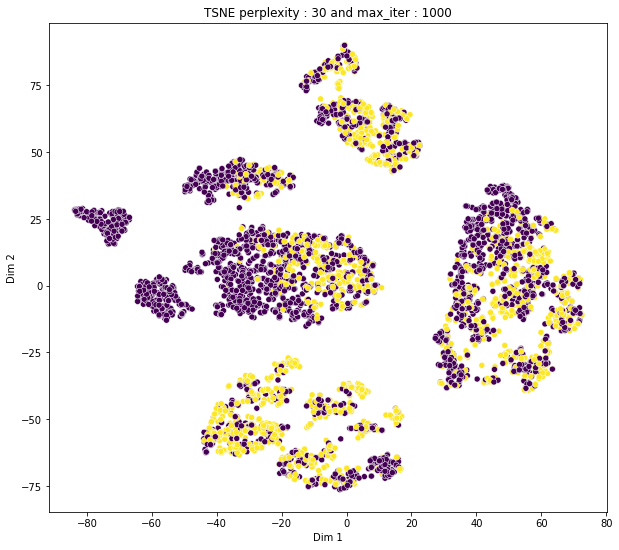

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
plt.figure(figsize = (10,9))
sns.scatterplot(x = df.x, y = df.y, c = y)
plt.title("TSNE perplexity : {} and max_iter : {}".format(30, 1000))
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

From the above plot, we notice that there is some form of separability, if not all.

**<h3>3D TSNE<h3>**

In [ ]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.044s...
[t-SNE] Computed neighbors for 5000 samples in 0.521s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.142424
[t-SNE] Computed conditional probabilities in 0.374s
[t-SNE] Iteration 50: error = 82.7610931, gradient norm = 0.0327160 (50 iterations in 10.756s)
[t-SNE] Iteration 100: error = 69.6307983, gradient norm = 0.0043697 (50 iterations in 6.349s)
[t-SNE] Iteration 150: error = 68.0120544, gradient norm = 0.0017049 (50 iterations in 5.291s)
[t-SNE] Iteration 200: error = 67.4367981, gradient norm = 0.0014371 (50 iterations in 5.129s)
[t-SNE] Iteration 250: error = 67.1217270, gradient norm = 0.000900

In [ ]:
def configure_plotly_browser_state():
      import IPython
      display(IPython.core.display.HTML('''
                 <script src="/static/components/requirejs/require.js"></script>
                 <script>
                      requirejs.config({
                          paths: {
                             base: '/static/base',
                            plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
                          },
                       });
                  </script>
                  '''))

In [ ]:
configure_plotly_browser_state()
trace1 = go.Scatter3d(
    x = tsne3d[:,0],
    y = tsne3d[:,1],
    z = tsne3d[:,2],
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data = [trace1]
layout = dict(height=800, width=800, title='3d embedding with engineered features')
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

We notice that there is some separability in 3-D as well. We now move on to the Text vectorization and Modelling.